In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

# jt -t monokai -N -T -kl -nfs 10 -tfs 10 -cellw 80%
from jupyterthemes import jtplot
jtplot.style(theme='monokai')

In [2]:
#export
from exp.nb_05b import *
torch.set_num_threads(2)

## ConvNet

In [3]:
x_train,y_train,x_valid,y_valid = get_data()

Helper function to quickly normalize with the mean and standard deviation from our training set:

In [4]:
#export
def normalize_to(train, valid):
    m,s = train.mean(),train.std()
    return normalize(train, m, s), normalize(valid, m, s)

In [5]:
x_train,x_valid = normalize_to(x_train,x_valid)
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

Let's check it behaved properly.

In [6]:
x_train.mean(),x_train.std()

(tensor(3.0614e-05), tensor(1.))

In [7]:
nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

To refactor layers, it's useful to have a `Lambda` layer that can take a basic function and convert it to a layer you can put in `nn.Sequential`.

NB: if you use a Lambda layer with a lambda function, your model won't pickle so you won't be able to save it with PyTorch. So it's best to give a name to the function you're using inside your Lambda (like flatten below).

In [8]:
#export
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x): return self.func(x)

def flatten(x):      return x.view(x.shape[0], -1)

This one takes the flat vector of size `bs x 784` and puts it back as a batch of images of 28 by 28 pixels:

In [9]:
def mnist_resize(x): return x.view(-1, 1, 28, 28)

We can now define a simple CNN.

In [10]:
def get_cnn_model(data):
    return nn.Sequential(
        Lambda(mnist_resize),
        nn.Conv2d( 1, 8, 5, padding=2,stride=2), # 14
        nn.ReLU(),
        nn.Conv2d( 8,16, 3, padding=1,stride=2), # 7
        nn.ReLU(),
        nn.Conv2d(16,32, 3, padding=1,stride=2), # 4
        nn.ReLU(),
        nn.Conv2d(32,32, 3, padding=1,stride=2), # 2
        nn.ReLU(),
        nn.AdaptiveAvgPool2d(1),
        Lambda(flatten),
        nn.Linear(32,data.c)
    )

In [11]:
model = get_cnn_model(data)

Basic callbacks from the previous notebook:

In [12]:
cbfs = [Recorder, partial(AvgStatsCallback,accuracy)]

In [13]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [14]:
%time run.fit(1, learn)

train: [1.79022796875, tensor(0.3946)]
valid: [0.76190576171875, tensor(0.7238)]
CPU times: user 9.19 s, sys: 573 ms, total: 9.76 s
Wall time: 3.75 s


In [15]:
loss_func

<function torch.nn.functional.cross_entropy(input, target, weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean')>

## CUDA

This took a long time to run, so it's time to use a GPU. A simple Callback can make sure the model, inputs and targets are all on the same device.

In [16]:
# Somewhat more flexible way
device = torch.device('cuda',0)

In [17]:
class CudaCallback(Callback):
    def __init__(self,device): self.device=device
    def begin_fit(self): self.model.to(self.device) # .to is part of PyTorch -- thisputs the model on GPU at beginning of fit
    def begin_batch(self): self.run.xb,self.run.yb = self.xb.to(self.device),self.yb.to(self.device) # this puts the batch to the GPU

In [18]:
# Somewhat less flexible, but quite convenient
torch.cuda.set_device(device) # this make so that when we call .cuda() the tensor is put on the `device` (cuda in our case)
# again, I find it silly we're refactoring to save a few characters in the callback, but ...

In [19]:
#export
class CudaCallback(Callback):
    def begin_fit(self): self.model.cuda()
    def begin_batch(self): self.run.xb,self.run.yb = self.xb.cuda(),self.yb.cuda()

In [20]:
cbfs.append(CudaCallback)

In [21]:
model = get_cnn_model(data)

In [22]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [23]:
%time run.fit(3, learn)

train: [2.04995078125, tensor(0.2690, device='cuda:0')]
valid: [1.007297265625, tensor(0.6877, device='cuda:0')]
train: [0.5018596484375, tensor(0.8410, device='cuda:0')]
valid: [0.2318132080078125, tensor(0.9274, device='cuda:0')]
train: [0.21185048828125, tensor(0.9340, device='cuda:0')]
valid: [0.139364013671875, tensor(0.9589, device='cuda:0')]
CPU times: user 8.04 s, sys: 1.79 s, total: 9.83 s
Wall time: 10.4 s


Now, that's definitely faster! (first time running there might be a little of overhead, re-run to get ~5s)

## Refactor model

First we can regroup all the conv/relu in a single function:

In [24]:
def conv2d(n_input, n_filters, kernel_size=3, stride=2):
    return nn.Sequential(
        nn.Conv2d(n_input, n_filters, kernel_size, padding=kernel_size//2, stride=stride), 
        nn.ReLU()
    )

Another thing is that we can do the mnist resize in a batch transform, rather than hard-coding it into the model. This way we could reuse the model on different data!
We can do that with a Callback.

In [25]:
#export
class BatchTransformXCallback(Callback):
    _order=2
    def __init__(self, transform_func): self.transform_func = transform_func # pass it a transform_func at construction
    def begin_batch(self): self.run.xb = self.transform_func(self.xb) # so xb on the runner (ie the batch) 
        #so it will apply transform_func at begin_batch each iteration

# let's define the transform_func we want        
def view_transform(*size): # this takes size as an unpacked but stores it as a tuple and then we do this weird bit *((-1,)+size) just to make code obscure
    def _inner(x): return x.view(*((-1,)+size)) # this first concat (-1,) to size and then unpacke it again. Assume size = (1,28,28) as for MNIST so we get
                                                # x.view(-1,1,28,28)
    return _inner

In [26]:
mnist_view = view_transform(1,28,28) # this is a specialization of the transform for MNIST size
cbfs.append(partial(BatchTransformXCallback, mnist_view)) # use partial ? why not BatchTransformXCallback(mnist_view)

In [27]:
# The reason is somewhat contort, but essentially we need to pass to the Runner a list of 'classes', not objects
a = partial(BatchTransformXCallback, mnist_view)
b = BatchTransformXCallback(mnist_view)
# `a` is a class, while `b` is an object!

# So when inside the Runner the callbacks are initialized (to extract name etc..) the code will call for cs in listify(cbfs): cb()
# but that will work for a (which is partially/completely specified but not instanciated) but not for b (cause now it expects the batch!)

print(a);print(a());print(b);print(b()) # you can see that `a()` is actually an object like `b` 

functools.partial(<class '__main__.BatchTransformXCallback'>, <function view_transform.<locals>._inner at 0x7f627edc1950>)


TypeError: __call__() missing 1 required positional argument: 'cb_name'

With the `AdaptiveAvgPool`, this model can now work on any size input:

In [28]:
num_filters = [8,16,32,32]

In [29]:
def get_cnn_layers(data, num_filters):
    num_filters = [1] + num_filters # the images are B/W so the first Conv layer takes 1 channel as input -- add that
    return [
        conv2d(num_filters[i], num_filters[i+1], 5 if i==0 else 3) # then for each of the num_filters create a conv layer 
        for i in range(len(num_filters)-1)                         # with num_filters[i] IN -> num_filters[i+1] OUT and kern_size=3 for all but the first
    ] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(num_filters[-1], data.c)] # + a last layer which is the `avgPooling, Flatten, Linear` layer

def get_cnn_model(data, num_filters): return nn.Sequential(*get_cnn_layers(data, num_filters))

And this helper function will quickly give us everything needed to run the training.

In [30]:
#export
def get_runner(model, data, lr=0.6, cbs=None, opt_func=None, loss_func = F.cross_entropy):
    if opt_func is None: opt_func = optim.SGD
    opt = opt_func(model.parameters(), lr=lr)
    learn = Learner(model, opt, loss_func, data)
    return learn, Runner(cb_funcs=listify(cbs))

In [31]:
model = get_cnn_model(data, num_filters)
learn,run = get_runner(model, data, lr=0.4, cbs=cbfs)

In [32]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): AdaptiveAvgPool2d(output_size=1)
  (5): Lambda()
  (6): Linear(in_features=32, out_features=10, bias=True)
)

In [33]:
run.fit(3, learn)

train: [2.200634375, tensor(0.2085, device='cuda:0')]
valid: [1.249830859375, tensor(0.5557, device='cuda:0')]
train: [0.685531953125, tensor(0.7793, device='cuda:0')]
valid: [0.23333173828125, tensor(0.9287, device='cuda:0')]
train: [0.2080283984375, tensor(0.9363, device='cuda:0')]
valid: [0.141090869140625, tensor(0.9580, device='cuda:0')]


## Hooks

### Manual insertion

Let's say we want to do some telemetry, and want the mean and standard deviation of each activations in the model. First we can do it manually, replacing our `SequenctialModel` class to `nn.Sequential`, like this:

In [34]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds  = [[] for _ in layers]
        
    def __call__(self, x):
        for i,l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(x.data.mean()) #and here we add a couple lines to store mean and std of the activations
            self.act_stds [i].append(x.data.std ())
        return x
    
    def __iter__(self): return iter(self.layers)

In [35]:
model =  SequentialModel(*get_cnn_layers(data, num_filters))
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [36]:
run.fit(2, learn)

train: [2.32044484375, tensor(0.1709, device='cuda:0')]
valid: [2.3004314453125, tensor(0.1064, device='cuda:0')]
train: [2.17733609375, tensor(0.2098, device='cuda:0')]
valid: [1.414794921875, tensor(0.4863, device='cuda:0')]


Now we can have a look at the means and stds of the activations at the beginning of training.

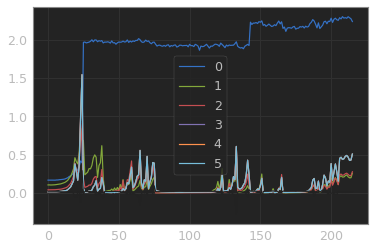

In [37]:
for l in model.act_means: plt.plot(l)
plt.legend(range(6));

So this is awful, you can see that the means start to grow exponentially ... untill they collapse. This happens a few times untill around iteration 120 they start to oscillate and probably training begins.

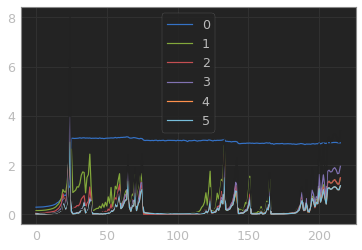

In [38]:
for l in model.act_stds: plt.plot(l)
plt.legend(range(6));

So similar behaviour for the stds...

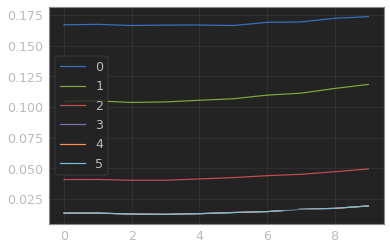

In [39]:
# Let's plot just the first 10 
for l in model.act_means: plt.plot(l[:10])
plt.legend(range(6));

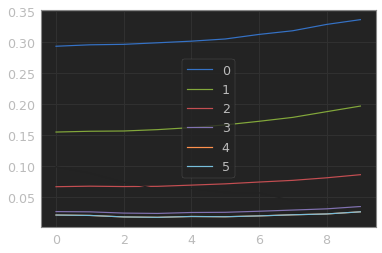

In [40]:
for l in model.act_stds: plt.plot(l[:10])
plt.legend(range(6));

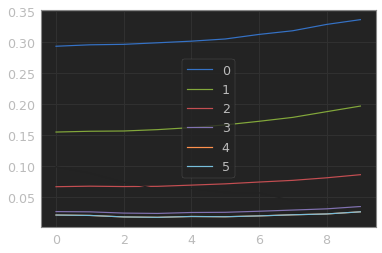

In [41]:
for l in model.act_stds: plt.plot(l[:10])
plt.legend(range(6));

The last layers have basically zero variance! So we know how to fix this, SMART INITIALIZATION!

But let's look at how to do smart telemetry again first! Right now we've written a class, but this can do only one type of telemetry (mean and stdev tracking). You don't want ot build a new class to replace SequentialModel each time for a different stat, so instead we want to do it with callbacks!

The problem is that we don't have a way to run a callback INSIDE a model (i.e. when you calculate this layer, call back to our code). We can't. But PyTorch can!

### Pytorch hooks

Hooks are PyTorch object you can add to any nn.Module. A hook will be called when a layer it is registered to, is executed during the forward pass (forward hook) or the backward pass (backward hook).

Hooks don't require us to rewrite the model class!

In [42]:
# so here we get the standard model
model = get_cnn_model(data, num_filters)
learn,run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [43]:
# We can declare the accumulators at the global scope now
act_means = [[] for _ in model]
act_stds  = [[] for _ in model]

A hook is attached to a layer, and needs to have a function that takes three arguments: module, input, output. Here we store the mean and std of the output in the correct position of our list.

In [44]:
def append_stats(i, mod, inp, outp):
    act_means[i].append(outp.data.mean())
    act_stds [i].append(outp.data.std())

In [45]:
# remember that our model is made of
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): AdaptiveAvgPool2d(output_size=1)
  (5): Lambda()
  (6): Linear(in_features=32, out_features=10, bias=True)
)

In [46]:
# Notice that Conv and ReLU are grouped together with our approach, because get_cnn_layers(data, num_filters) returns
# a list of sequentials (due to the function that couples conv and relu) and then the last few layers,
# and then this list in unpacked and fed to a nn.Sequential again to make our model
get_cnn_layers(data, num_filters)

[Sequential(
   (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
   (1): ReLU()
 ), Sequential(
   (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (1): ReLU()
 ), Sequential(
   (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (1): ReLU()
 ), Sequential(
   (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (1): ReLU()
 ), AdaptiveAvgPool2d(output_size=1), Lambda(), Linear(in_features=32, out_features=10, bias=True)]

In [47]:
for i,module in enumerate(model): module.register_forward_hook(partial(append_stats, i))

In [48]:
run.fit(2, learn)

train: [1.52549765625, tensor(0.4828, device='cuda:0')]
valid: [0.361872216796875, tensor(0.8828, device='cuda:0')]
train: [0.2558151171875, tensor(0.9227, device='cuda:0')]
valid: [0.16198114013671874, tensor(0.9524, device='cuda:0')]


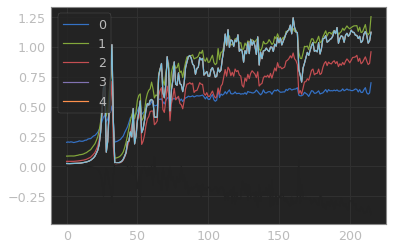

In [49]:
for o in act_means: plt.plot(o)
plt.legend(range(5));

Same as before ... ok!

### Hook class

### We can (and should) refactor this in a Hook class. 
#### It's very important to remove the hooks when they are deleted, otherwise there will be references kept and the memory won't be properly released when your model is deleted.
So we're probably leaking the few hooks we had in the previous model ... -.-

In [50]:
#export
def children(m): return list(m.children())

class Hook():
    def __init__(self, module, func, forward=True):
        self.forward = forward
        self.hook = module.register_forward_hook(partial(func, self)) if self.forward else module.register_backward_hook(partial(func, self))
    def remove(self): self.hook.remove() # this seems silly, but it's because we might want to keep the Hook (this class )around
    def __del__(self): self.remove()     # because it stores the stats, while we definitely want to remove the (PyTorch) hook 

def append_stats(hook, module, input, output): # so now instead of passing the layer (previously `i`) we partial with self, which is a Hook
    if not hasattr(hook,'stats'): hook.stats = ([],[]) # add the stat lists if not present and then save the stats
    means,stds = hook.stats
    if hook.forward:
        means.append(output.data.mean())
        stds .append(output.data.std())
    else:
        means.append(input.data.mean())
        stds .append(input.data.std())

NB: In fastai we use a `bool` param to choose whether to make it a forward or backward hook. In the above version we're only supporting forward hooks.

In [51]:
model = get_cnn_model(data, num_filters)
learn,run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [52]:
hooks = [Hook(l, append_stats) for l in children(model[:4])] # list of Hooks (class objects) that, at __init__ register a hook to each l in children(model)

In [53]:
children(model[:4])

[Sequential(
   (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
   (1): ReLU()
 ), Sequential(
   (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (1): ReLU()
 ), Sequential(
   (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (1): ReLU()
 ), Sequential(
   (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (1): ReLU()
 )]

In [54]:
run.fit(1, learn)

train: [2.03338046875, tensor(0.2915, device='cuda:0')]
valid: [1.0390345703125, tensor(0.6568, device='cuda:0')]


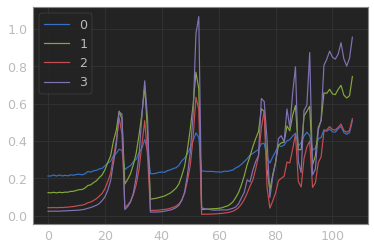

In [55]:
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(4));

Ok, so still same thing but done better! Can we make it even better?

### A Hooks class

Let's design our own class that can contain a list of objects. It will behave a bit like a numpy array in the sense that we can index into it via:
- a single index
- a slice (like 1:5)
- a list of indices
- a mask of indices (`[True,False,False,True,...]`)

The `__iter__` method is there to be able to do things like `for x in ...`.

In [56]:
#export
class ListContainer():
    def __init__(self, items): self.items = listify(items) # so the items we pass in are "listified", a list is the internal storage repr
    def __getitem__(self, idx):                                     # __getitem__ is the operator[] of python
        if isinstance(idx, (int,slice)): return self.items[idx]     # for int and slices lists work out of the box, so just pass it on
        if isinstance(idx[0],bool):                                 # for bool first check that the mask has the same length of items
            assert len(idx)==len(self) # bool mask                  
            return [o for m,o in zip(idx,self.items) if m]          # if so iterate through it
        return [self.items[i] for i in idx]
    def __len__(self): return len(self.items)
    def __iter__(self): return iter(self.items)
    def __setitem__(self, i, o): self.items[i] = o
    def __delitem__(self, i): del(self.items[i])
    def __repr__(self):
        res = f'{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}' # repr cut the string to 10 elements and print ellipses in that case
        if len(self)>10: res = res[:-1]+ '...]'
        return res

So essentally a list with the ability to index things with a boolean mask, why couldn't we just change the __getitem__  of a list object by inheriting?

In [57]:
ListContainer(range(10))

ListContainer (10 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [58]:
ListContainer(range(100))

ListContainer (100 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9...]

In [59]:
t = ListContainer(range(10))
t[[1,2]], t[[False]*8 + [True,False]]

([1, 2], [8])

We can use it to write a `Hooks` class that contains several hooks. We will also use it in the next notebook as a container for our objects in the data block API.

In [60]:
#export
from torch.nn import init

# a fancy list of Hook objects
class Hooks(ListContainer):
    def __init__(self, ms, f): super().__init__([Hook(m, f) for m in ms])
    def __enter__(self, *args): return self
    def __exit__ (self, *args): self.remove()
    def __del__(self): self.remove()

    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
        
    def remove(self):
        for h in self: h.remove()

In [61]:
model = get_cnn_model(data, num_filters).cuda()
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [62]:
hooks = Hooks(model, append_stats) # add the append_stat callback as a hook to each layer of model
hooks

Hooks (7 items)
[<__main__.Hook object at 0x7f62747f36a0>, <__main__.Hook object at 0x7f62747f39b0>, <__main__.Hook object at 0x7f62747e7fd0>, <__main__.Hook object at 0x7f62747e7710>, <__main__.Hook object at 0x7f62747e7eb8>, <__main__.Hook object at 0x7f62747e72b0>, <__main__.Hook object at 0x7f62747e7358>]

In [63]:
hooks.remove() # remove every hook

## Ok now let'd deal with the initialization problem

We'll use kaiming_normal on every layer

In [64]:
x,y = next(iter(data.train_dl))
x = mnist_resize(x).cuda()

In [65]:
x.mean(),x.std()

(tensor(0.0043, device='cuda:0'), tensor(1.0038, device='cuda:0'))

In [66]:
model[0]

Sequential(
  (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (1): ReLU()
)

In [67]:
model[0][0]

Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))

In [68]:
# for each convolutional module we can extracts weights and biases with the parameters() generator,
# but in nn.Conv2d there's an attribute called weight that store the convolutional kernels in a tensor
#list(model[0][0].parameters())
model[0][0].weight.shape # 8 5x5(x1channel) kernels

torch.Size([8, 1, 5, 5])

In [69]:
p = model[0](x)
p.mean(),p.std()
# as expected std is way lower than one (and the mean a tad over 0. because fo ReLU)

(tensor(0.1601, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.3291, device='cuda:0', grad_fn=<StdBackward0>))

In [70]:
# for each layer, init the weights with kaiming -- default is fan_in (i.e. using the n_input) and "leaky-ReLU" with a=0 (so ReLU) 
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [71]:
p = model[0](x)
p.mean(),p.std()
# WAY BETTER, now at least after one layer we preserve the correct variance

(tensor(0.4356, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.8536, device='cuda:0', grad_fn=<StdBackward0>))

Having given an `__enter__` and `__exit__` method to our `Hooks` class, we can use it as a context manager. This makes sure that onces we are out of the `with` block, all the hooks have been removed and aren't there to pollute our memory.

train: [1.96549, tensor(0.3374, device='cuda:0')]
valid: [0.758583251953125, tensor(0.7748, device='cuda:0')]
train: [0.5573210546875, tensor(0.8235, device='cuda:0')]
valid: [0.2454345703125, tensor(0.9253, device='cuda:0')]


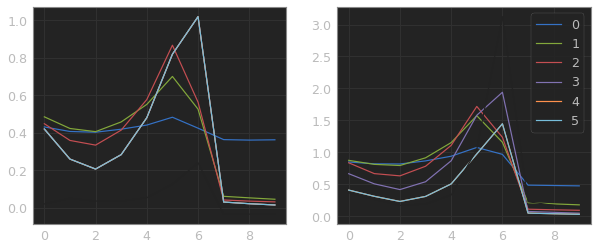

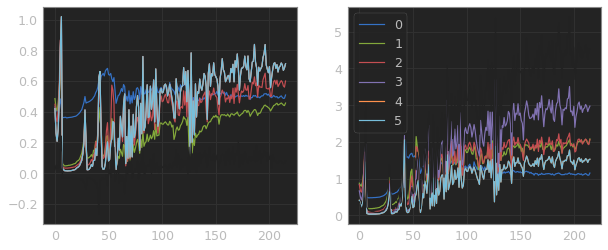

In [72]:
with Hooks(model, append_stats) as hooks: #  create a hooks obj which registers hooks with append_stats to each layer
    run.fit(2, learn) # run for 2 epochs
    
    # print the first 10 iterations
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
    plt.legend(range(6));
    
    # print all
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(6));

Good, now the dangerous oscillations are dampened and stop very soon; we start training properly quite early

### Other statistics

Let's store more than the means and stds and plot histograms of our activations now.

In [73]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[],[]) # dict would probably be better -- TODO?
    means,stds,hists = hook.stats
    means.append(outp.data.mean().cpu())
    stds .append(outp.data.std().cpu())
    hists.append(outp.data.cpu().histc(40,0,10)) #histc isn't implemented on the GPU

In [74]:
# to get info on what histc is
torch.histc??

In [75]:
model = get_cnn_model(data, num_filters).cuda()
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [76]:
# re-do the kaiming init
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [77]:
with Hooks(model, append_stats) as hooks: run.fit(1, learn) 
    # remember that at __exit__ the Hooks object is not destroyed, we only remove the pt hook from model

train: [2.03914625, tensor(0.3028, device='cuda:0')]
valid: [1.09089609375, tensor(0.6524, device='cuda:0')]


Let's try to analyze what those histograms are:

In [78]:
hooks[0].stats[2][0].shape

torch.Size([40])

(array([11.,  0.,  3.,  3.,  4.,  6.,  7.,  2.,  3.,  1.]),
 array([ 0.      ,  1.316427,  2.632853,  3.949279,  5.265706,  6.582132,  7.898559,  9.214985, 10.531412, 11.847838,
        13.164265], dtype=float32),
 <a list of 10 Patch objects>)

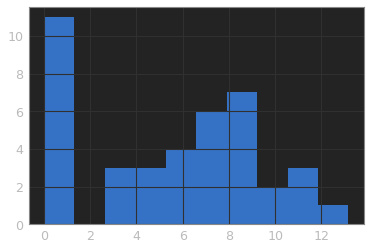

In [79]:
# so each is a tensor of size 40 (the number of bins we selected) and can be plotted as a single histogram like this:
plt.hist(hooks[0].stats[2][0].float().log1p())

In [80]:
# Remember this is just for the first iteration!
# We can then stack more than one by using toch.stack
torch.stack(hooks[0].stats[2][:3]).shape

torch.Size([3, 40])

([array([11.,  0.,  3.,  3.,  4.,  6.,  7.,  2.,  3.,  1.]),
  array([10.,  2.,  1.,  4.,  4.,  7.,  6.,  2.,  3.,  1.]),
  array([9., 1., 2., 4., 4., 7., 7., 2., 3., 1.])],
 array([ 0.      ,  1.316427,  2.632853,  3.949279,  5.265706,  6.582132,  7.898559,  9.214985, 10.531412, 11.847838,
        13.164265], dtype=float32),
 <a list of 3 Lists of Patches objects>)

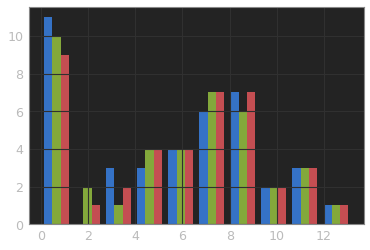

In [81]:
plt.hist(torch.stack(hooks[0].stats[2][:3]).float().log1p())

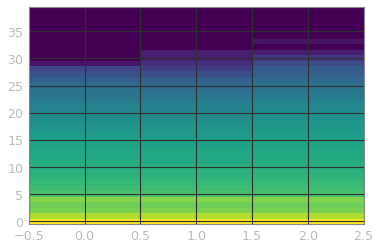

In [82]:
# What if instead we'd plot them as an image? (note, it's transposed so zero on the bottom - horizontally)
plt.imshow(torch.stack(hooks[0].stats[2][:3]).float().log1p().t(), origin='lower',aspect='auto')

### A few notes: 
 The two "histograms" are now plotted side to side, rather than interleaved,
    so the evolution over the iterations goes from LEFT TO RIGHT
    
 Here Colours represent what was the height of the bar before. We're plotting it as a one-channel image
    so yellow, bright, is a high bar
 
 On the y axis are the bins, from zero to the max value (which was around 12 but it's lost in this plot)
 
 OK, let's see them all!

In [83]:
# Thanks to @ste for initial version of histgram plotting code
def get_hist(h): return torch.stack(h.stats[2]).t().float().log1p()

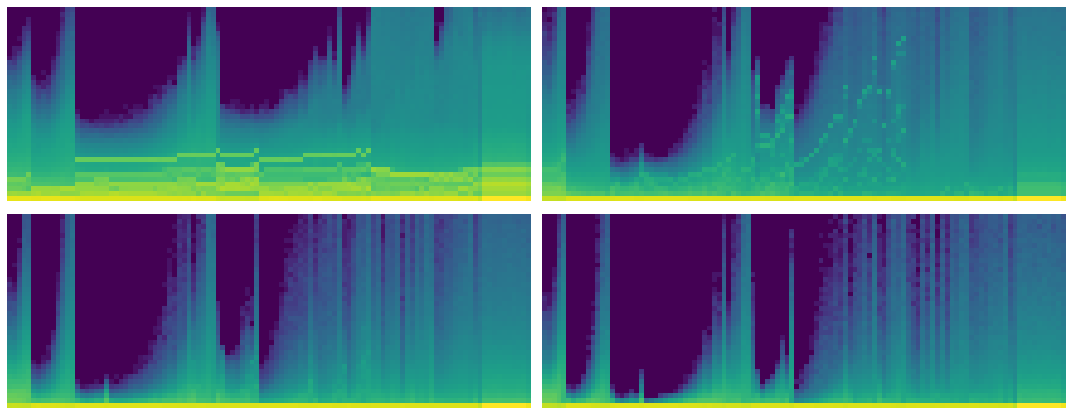

In [84]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()

From this, we can easily get more informations like the **PERCENTAGES OF** min or max of the activations, by extracting it from the histogram bins
the fact that Jeremy calls them min and max is a bit misleading IMHO

In [85]:
hh = torch.stack(hooks[0].stats[2]).float().t(); hh.shape #108 iters for 40 bins

torch.Size([40, 108])

In [86]:
hh[:2,0], hh[:2].sum(0)[0], hh[:2,0].sum()

(tensor([521395., 109507.]), tensor(630902.), tensor(630902.))

In [87]:
def get_min_pct(h):
    h1 = torch.stack(h.stats[2]).t().float() # h1 is the hist as before
    return h1[:2].sum(0)/h1.sum(0) # what is the percentage of elements in the smallest two bins?

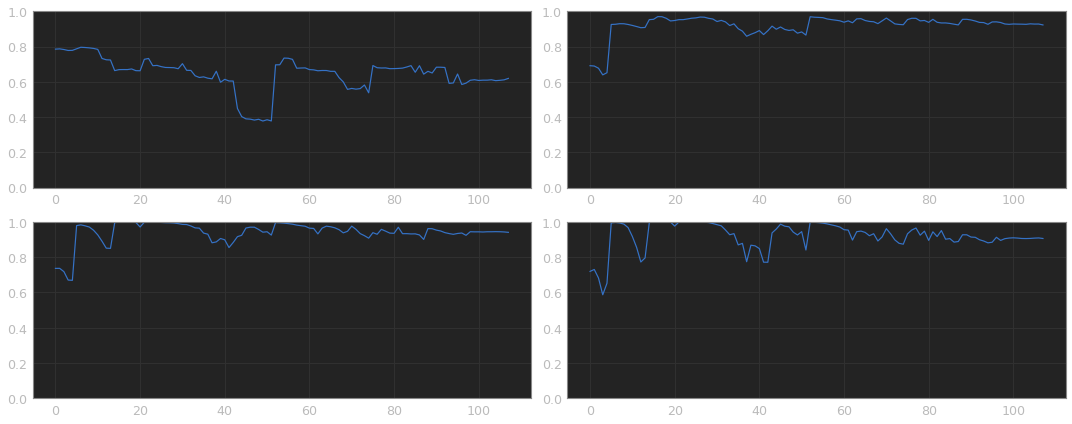

In [88]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min_pct(h))
    ax.set_ylim(0,1)
plt.tight_layout()

So very high percentage of the activations is basically zero! We're not learning much it seems...

## Generalized ReLU

Now let's use our model with a generalized ReLU that can be shifted and with maximum value.

In [89]:
#export
def get_cnn_layers(data, nfs, layer, **kwargs):
    nfs = [1] + nfs
    return [layer(nfs[i], nfs[i+1], 5 if i==0 else 3, **kwargs)
            for i in range(len(nfs)-1)] + [
        nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def conv_layer(ni, nf, ks=3, stride=2, **kwargs):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), GeneralRelu(**kwargs))

class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak,self.sub,self.maxv = leak,sub,maxv

    def forward(self, x): 
        x = F.leaky_relu(x,self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x.sub_(self.sub)
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x

def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    for l in m:
        if isinstance(l, nn.Sequential):
            f(l[0].weight, a=0.1)
            l[0].bias.data.zero_()

def get_cnn_model(data, nfs, layer, **kwargs):
    return nn.Sequential(*get_cnn_layers(data, nfs, layer, **kwargs))

In [90]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[],[])
    means,stds,hists = hook.stats
    means.append(outp.data.mean().cpu())
    stds .append(outp.data.std().cpu())
    hists.append(outp.data.cpu().histc(40,-7,7))

In [91]:
model =  get_cnn_model(data, num_filters, conv_layer, leak=0.1, sub=0.4, maxv=6.)
init_cnn(model)
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

train: [0.4888084765625, tensor(0.8446, device='cuda:0')]
valid: [0.14513067626953124, tensor(0.9559, device='cuda:0')]


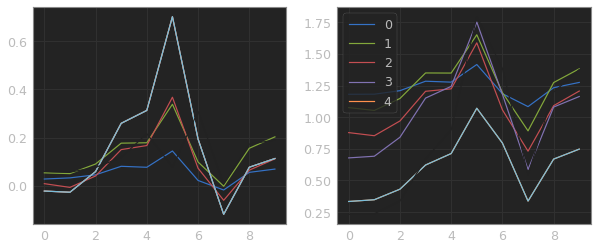

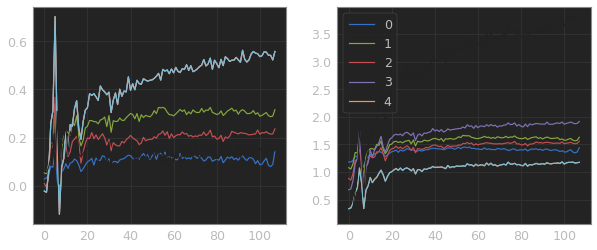

In [92]:
with Hooks(model, append_stats) as hooks:
    run.fit(1, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss,hi = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(5));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss,hi = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(5));

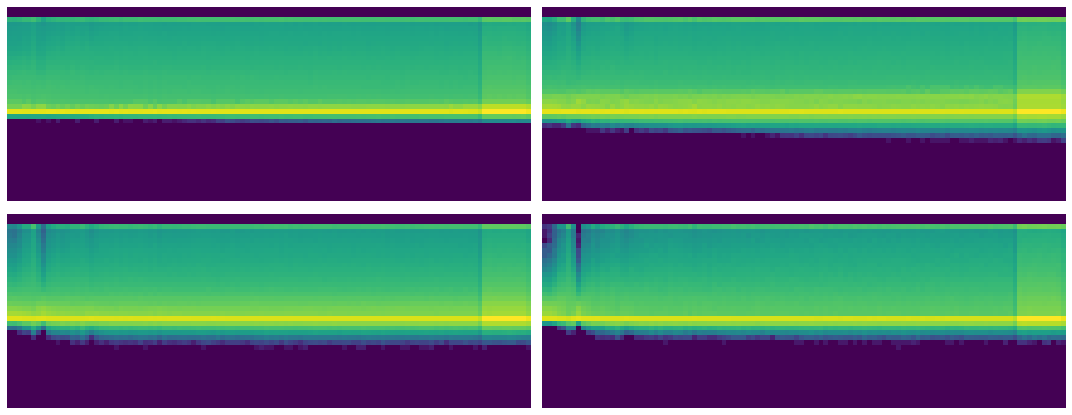

In [93]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()

Seems better, the histogram seems a bit more yellowy overall, indicating a more spreaded distribution of the activations

In [94]:
def get_min_pct(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[19:22].sum(0)/h1.sum(0) #  zero is now in the middle of the bins

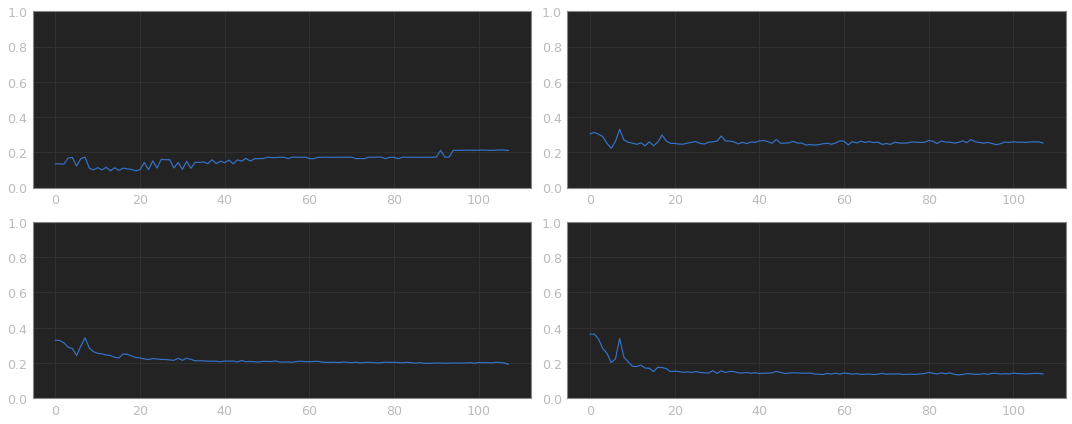

In [95]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min_pct(h))
    ax.set_ylim(0,1)
plt.tight_layout()

So now very few beans are stuck exactly at zero!

Let's try now to learn for a few more epochs!

In [96]:
#export
def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [97]:
sched = combine_scheds([0.5, 0.5], [sched_cos(0.2, 1.), sched_cos(1., 0.1)]) 

In [98]:
nfs = num_filters
learn,run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs+[partial(ParamScheduler,'lr', sched)])

In [99]:
run.fit(8, learn)

train: [1.198618828125, tensor(0.6294, device='cuda:0')]
valid: [0.3749392578125, tensor(0.8866, device='cuda:0')]
train: [0.31222779296875, tensor(0.9056, device='cuda:0')]
valid: [0.186979052734375, tensor(0.9482, device='cuda:0')]
train: [0.720963125, tensor(0.7859, device='cuda:0')]
valid: [0.94187958984375, tensor(0.7147, device='cuda:0')]
train: [0.24889732421875, tensor(0.9257, device='cuda:0')]
valid: [0.12861812744140624, tensor(0.9603, device='cuda:0')]
train: [0.11480484375, tensor(0.9644, device='cuda:0')]
valid: [0.0912853759765625, tensor(0.9729, device='cuda:0')]
train: [0.0745812060546875, tensor(0.9768, device='cuda:0')]
valid: [0.07360885009765625, tensor(0.9778, device='cuda:0')]
train: [0.0558591064453125, tensor(0.9831, device='cuda:0')]
valid: [0.06847518920898438, tensor(0.9800, device='cuda:0')]
train: [0.0476199560546875, tensor(0.9855, device='cuda:0')]
valid: [0.06675587158203125, tensor(0.9807, device='cuda:0')]


Uniform init may provide more useful initial weights (normal distribution puts a lot of them at 0).

In [100]:
learn,run = get_learn_run(nfs, data, 1., conv_layer, uniform=True, # here we switch to kaiming_uniform_
                          cbs=cbfs+[partial(ParamScheduler,'lr', sched)])

In [101]:
run.fit(8, learn)

train: [0.99388, tensor(0.6995, device='cuda:0')]
valid: [0.340505517578125, tensor(0.8927, device='cuda:0')]
train: [0.3128035546875, tensor(0.9073, device='cuda:0')]
valid: [0.165968994140625, tensor(0.9516, device='cuda:0')]
train: [0.2139106640625, tensor(0.9352, device='cuda:0')]
valid: [0.11504647216796875, tensor(0.9662, device='cuda:0')]
train: [0.2368492578125, tensor(0.9290, device='cuda:0')]
valid: [0.1050493408203125, tensor(0.9676, device='cuda:0')]
train: [0.083898408203125, tensor(0.9745, device='cuda:0')]
valid: [0.08260866088867187, tensor(0.9783, device='cuda:0')]
train: [0.05859814453125, tensor(0.9823, device='cuda:0')]
valid: [0.0749116455078125, tensor(0.9802, device='cuda:0')]
train: [0.043000341796875, tensor(0.9875, device='cuda:0')]
valid: [0.058490576171875, tensor(0.9834, device='cuda:0')]
train: [0.0351823828125, tensor(0.9899, device='cuda:0')]
valid: [0.05806058959960937, tensor(0.9834, device='cuda:0')]


## Export

Here's a handy way to export our module without needing to update the file name - after we define this, we can just use `nb_auto_export()` in the future (h/t Stas Bekman):

In [4]:
#export
from IPython.display import display, Javascript
def nb_auto_export():
    display(Javascript("""{
const ip = IPython.notebook
if (ip) {
    ip.save_notebook()
    console.log('a')
    const s = `!python3 notebook2script.py ${ip.notebook_name}`
    if (ip.kernel) { ip.kernel.execute(s) }
}
}"""))

In [ ]:
nb_auto_export()